In [1]:
import numpy as np
import networkx as nx
from loguru import logger as log
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import qtree 
import utils
import utils_qaoa as qaoa

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


In [2]:
def get_test_graph(S):
    #G = nx.triangular_lattice_graph(S, S)
    G = nx.grid_2d_graph(S+1, (2+S)//2)
    # remove grid labelling
    gen = (x for x in range(G.number_of_nodes()))
    G = nx.relabel_nodes(G, lambda x: next(gen))
    return G

def get_test_qaoa(S, p):
    G = get_test_graph(S)
    N = G.number_of_nodes()
    beta, gamma = [np.pi/3]*p, [np.pi/2]*p
    qc = qaoa.get_qaoa_circuit(G, beta, gamma)
    return qc, N

def get_test_expr_graph(S, p):
    qc, N = get_test_qaoa(S, p)
    graph = qtree.graph_model.circ2graph(N, qc)
    return graph, N

def get_optimized_expr(S, p):
    graph, N = get_test_expr_graph(S, p)
    graph_opt, nghs = _optimise_graph(graph)
    return graph_opt, nghs, N

def _optimise_graph(graph):
    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    graph_opt, slice_dict = utils.reorder_graph(graph, peo)
    return graph_opt, nghs

def get_splitted_graph(S, p, pars):
    graph, N = get_test_expr_graph(S, p)
    idxs, graph = qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=pars)
    graph_opt, nghs = _optimise_graph(graph)
    return graph, nghs, N

def get_cost_of_splitted(S, p, pars):
    graph, nghs, N = get_splitted_graph(S, p, pars)
    graph_opt, nghs = _optimise_graph(graph)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

def get_cost_of_task(S, p=1):
    graph_opt, nghs, N = get_optimized_expr(S, p)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

## Example of per-step cost

2020-03-07 16:17:51,025- INFO•	Generated graph with 976 nodes and 2136 edges


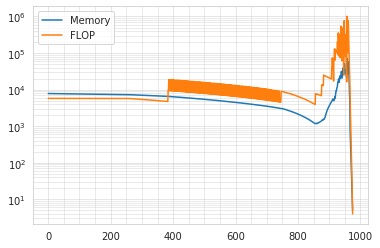

In [6]:
mems, flops, nghs, N = get_cost_of_task(15)
utils.plot_cost(mems, flops)

## Cost vs qubits size 

In [5]:
def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')
    
def get_est(xs, vals):
    mem_est = np.polyfit(np.log(xs), np.log(vals), 2)
    mem_est = np.poly1d(mem_est)
    est = np.linspace(20,1e2, 100)
    est = np.log(est)
    mem_est = mem_est(est)
    return np.exp(est),  np.exp(mem_est)

In [ ]:
sizes = np.arange(5,17,1)
results = [
   get_cost_of_task(s, 3) for s in sizes
]
def plot_theory(results):
    sums = [[sum(x) for x in y[:3]] for y in results]
    memsums, flopsums, nghssums = zip(*sums)
    ns = list(zip(*results))[3]

    est, mem_est = get_est(ns, memsums)
    est, flop_est = get_est(ns, flopsums)


    plt.plot(ns, memsums, label='mem sum')
    plt.plot(ns, flopsums, label='flop sum')
    plt.plot(est, mem_est, '--', label='mem log-log fit')
    plt.plot(est, flop_est, '--', label='flop log-log fit')

    plt.xlabel('Number of qbits')
    plt.yscale('log')
    plt.xscale('log')
    plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
    plt.title('MaxCut triangular grids')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

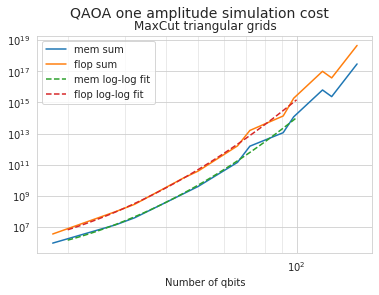

In [125]:
plot_theory(results)


## Cost with respect to depth


In [7]:
psize = 4
Ssize = 9

costs_with_p = []
for p in range(1, 1+psize):
    for S in range(2, 2+Ssize):
        costs = get_cost_of_task(S, p)
        costs_with_p.append(costs)

2020-03-07 16:18:07,835- INFO•	Generated graph with 38 nodes and 73 edges
2020-03-07 16:18:07,866- INFO•	Generated graph with 52 nodes and 102 edges
2020-03-07 16:18:07,936- INFO•	Generated graph with 104 nodes and 214 edges
2020-03-07 16:18:08,172- INFO•	Generated graph with 126 nodes and 261 edges
2020-03-07 16:18:08,396- INFO•	Generated graph with 202 nodes and 427 edges
2020-03-07 16:18:08,866- INFO•	Generated graph with 232 nodes and 492 edges
2020-03-07 16:18:09,428- INFO•	Generated graph with 332 nodes and 712 edges
2020-03-07 16:18:10,666- INFO•	Generated graph with 370 nodes and 795 edges
2020-03-07 16:18:12,280- INFO•	Generated graph with 494 nodes and 1069 edges
2020-03-07 16:18:15,233- INFO•	Generated graph with 64 nodes and 140 edges
2020-03-07 16:18:15,289- INFO•	Generated graph with 88 nodes and 196 edges
2020-03-07 16:18:15,505- INFO•	Generated graph with 178 nodes and 413 edges
2020-03-07 16:18:15,944- INFO•	Generated graph with 216 nodes and 504 edges
2020-03-07 16:18

(4, 4, 9)


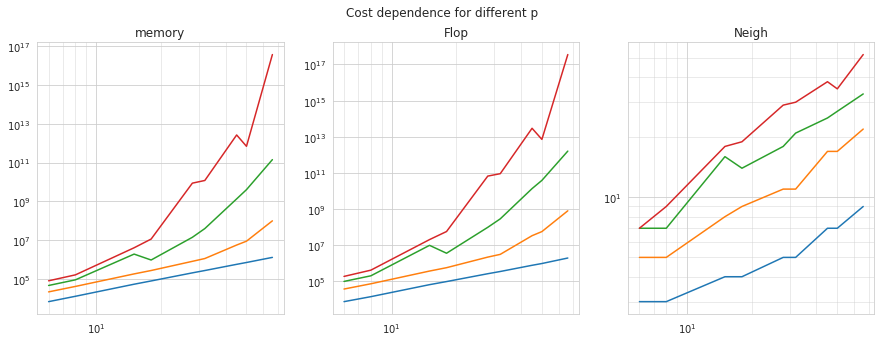

In [9]:

costs_with_p_p= [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_p]
data = np.array(list(zip(*costs_with_p_p)))

data = data.reshape(4, psize, Ssize)
print(data.shape)

fig, axs = plt.subplots(1,3, figsize=(15, 5))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(psize):
    plt.plot(data[-1,i], data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(psize):
    plt.plot(data[-1,i], data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(psize):
    plt.plot(data[-1,i], data[2,i])

plt.suptitle('Cost dependence for different p')
plt.savefig('figures/cost_vs_p.png')

In [22]:
psize = 3
Ssize = 3
p = 1

costs_with_pars = []
for pars in range(1, 1+psize):
    for S in range(25, 25+Ssize):
        costs = get_cost_of_splitted(S, p, pars)
        costs_with_pars.append(costs)
       

2020-03-07 18:34:38,667- INFO•	Generated graph with 2626 nodes and 5811 edges
2020-03-07 18:34:38,883- INFO•	Removed indices by parallelization:
[705]
2020-03-07 18:34:38,884- INFO•	Removed 1 variables
2020-03-07 18:36:28,152- INFO•	Generated graph with 2942 nodes and 6517 edges
2020-03-07 18:36:28,286- INFO•	Removed indices by parallelization:
[787]
2020-03-07 18:36:28,287- INFO•	Removed 1 variables
2020-03-07 18:39:14,285- INFO•	Generated graph with 3052 nodes and 6762 edges
2020-03-07 18:39:14,512- INFO•	Removed indices by parallelization:
[815]
2020-03-07 18:39:14,512- INFO•	Removed 1 variables
2020-03-07 18:41:51,030- INFO•	Generated graph with 2626 nodes and 5811 edges
2020-03-07 18:41:51,133- INFO•	Removed indices by parallelization:
[705, 707]
2020-03-07 18:41:51,134- INFO•	Removed 2 variables
2020-03-07 18:44:09,287- INFO•	Generated graph with 2942 nodes and 6517 edges
2020-03-07 18:44:09,580- INFO•	Removed indices by parallelization:
[787, 789]
2020-03-07 18:44:09,581- INFO•	

(4, 3, 3)


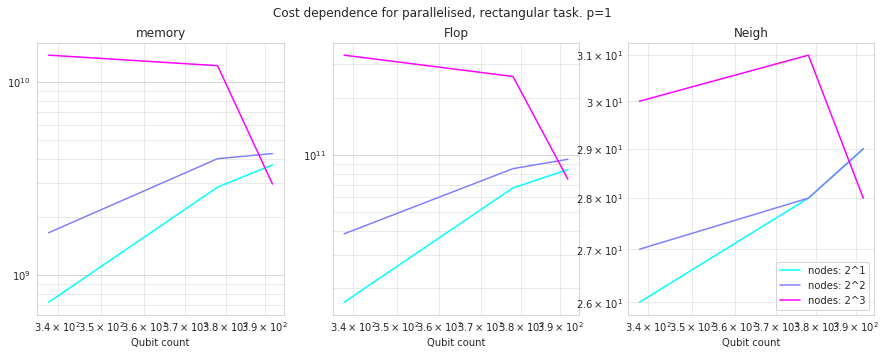

In [23]:


costs_with_p_ = [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_pars]
data = np.array(list(zip(*costs_with_p_)))

data = data.reshape(4, psize, Ssize)
print(data.shape)

fig, axs = plt.subplots(1,3, figsize=(15, 5))
colormap = plt.cm.gist_ncar
labels = [f'nodes: 2^{i}' for i in range(1, 1+psize)]
for ax in axs:
    ax.set_prop_cycle(plt.cycler('color', plt.cm.cool(np.linspace(0, 1, psize))))
    ax.set_xlabel('Qubit count')

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(psize):
    plt.plot(data[-1,i], data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(psize):
    plt.plot(data[-1,i], data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(psize):
    plt.plot(data[-1,i], data[2,i])
plt.legend(labels)

plt.suptitle('Cost dependence for parallelised, rectangular task. p=1')
plt.savefig('figures/rect_cost_vs_nodes_p1.png')

(4, 3, 3)


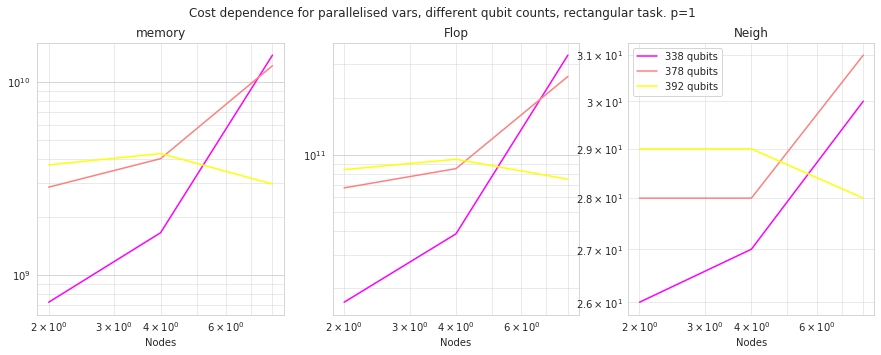

In [24]:

costs_with_p_ = [(sum(x[0]), sum(x[1]), max(x[2]), x[3]) for x in costs_with_pars]
data = np.array(list(zip(*costs_with_p_)))

data = data.reshape(4, psize, Ssize)
data = data.transpose(0,2,1)
print(data.shape)
processes = 2**(np.arange(1, 1+psize))
fig, axs = plt.subplots(1,3, figsize=(15, 5))
for ax in axs:
    ax.set_xlabel('Nodes')
    ax.set_prop_cycle(plt.cycler('color', plt.cm.spring(np.linspace(0, 1, psize))))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.title('memory')
for i in range(Ssize):
    plt.plot(processes, data[0,i])
    
plt.sca(axs[1])
log_log_scale()
minorticks()
plt.title('Flop')
for i in range(Ssize):
    plt.plot(processes, data[1,i])
    
plt.sca(axs[2])
log_log_scale()
minorticks()
plt.title('Neigh')
for i in range(Ssize):
    plt.plot(processes, data[2,i])

labels = [f'{int(i)} qubits' for i in data[-1,:, 0]]
plt.legend(labels)
plt.suptitle('Cost dependence for parallelised vars, different qubit counts, rectangular task. p=1')
plt.savefig('figures/rect_cost_vs_nodes_T_p1.png')
jjj

In [291]:
graph, N = get_test_expr_graph(35, 1)
print(N)

2020-03-07 22:39:00,310- INFO•	Generated graph with 5076 nodes and 11286 edges


648


15399.6052399
466192.930177024
CPU times: user 6min 26s, sys: 272 ms, total: 6min 26s
Wall time: 6min 28s


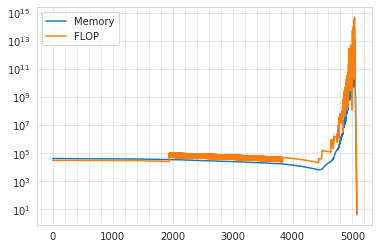

In [292]:
%%time
peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
graph_relabel, slice_dict = utils.reorder_graph(graph, peo)

costs, flops = qtree.graph_model.cost_estimator(graph_relabel)
print(max(costs)/1e9)
print(max(flops)/1e9)
utils.plot_cost(costs, flops)

#nx.draw_kamada_kawai(graph, node_size=3)

In [164]:
#%cd ..

In [293]:
%%time
peoqbb, tw = qtree.graph_model.get_peo(graph)

2020-03-07 22:45:59,341- INFO•	generating config file output/quickbb.10139916.cnf
2020-03-07 22:45:59,351- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.10139916.cnf 


TypeError: 'NoneType' object is not subscriptable

In [294]:
graph, slice_dict = utils.reorder_graph(graph, peoqbb)

costs, mems = qtree.graph_model.cost_estimator(graph)
print(max(mems)/1e8)
print(max(costs)/1e8)
utils.plot_cost(costs, mems)
    

KeyError: 648

23.15255808


1351079888.2111487
43628621.39015268
CPU times: user 3min 23s, sys: 87.2 ms, total: 3min 24s
Wall time: 3min 25s


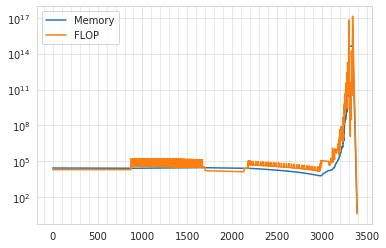

In [270]:
%%time
peon, nghs = utils.get_neighbours_peo(graph)
graph_relabel, slice_dict = utils.reorder_graph(graph, peon)

costs, mems = qtree.graph_model.cost_estimator(graph_relabel)
print(max(mems)/1e8)
print(max(costs)/1e8)
utils.plot_cost(costs, mems)

In [184]:
peo, nghs = utils.get_locale_peo(graph, utils.edges_to_clique)
graph_relabel, slice_dict = utils.reorder_graph(graph, peo)

costs, mems = qtree.graph_model.cost_estimator(graph_relabel)
utils.plot_cost(costs, mems)

/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py:517: RuntimeWarning: overflow encountered in long_scalars
  flops = (size_of_the_result *
/home/dali/anl/qsim/qtree/qtree/graph_model/graph_model.py:507: RuntimeWarning: overflow encountered in long_scalars
  memory += mem


KeyboardInterrupt: 

In [295]:
for n in peo[:4100]:
    qtree.graph_model.eliminate_node(graph, n)
    

/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


[3628, 3632, 3636, 3640, 3644, 3648, 3652, 3656, 3660, 3664, 3668, 3672, 3678, 3682, 3686, 3690, 3694, 3698, 3702, 3706, 3710, 3714, 3718, 3722, 3726, 3730, 3734, 3738, 3742, 3748, 3752, 3756, 3760, 3764, 3768, 3772, 3776, 3780, 3784, 3788, 3792, 3796, 3800, 3804, 3808, 3812, 3818, 3822, 3826, 3830, 3834, 3838, 3842, 3846, 3850, 3854, 3858, 3862, 3866, 3870, 3874, 3878, 3882, 3888, 3892, 3896, 3900, 3904, 3908, 3912, 3916, 3920, 3924, 3928, 3932, 3936, 3940, 3944, 3948, 3952, 3958, 3962, 3966, 3970, 3974, 3978, 3982, 3986, 3990, 3994, 3998, 4002, 4006, 4010, 4014, 4018, 4022, 4028, 4032, 4036, 4040, 4044, 4048, 4052, 4056, 4060, 4064, 4068, 4072, 4076, 4080, 4084, 4088, 4092, 4098, 4102, 4106, 4110, 4114, 4118, 4122, 4126, 4130, 4134, 4138, 4142, 4146, 4150, 4154, 4158, 4162, 4168, 4172, 4176, 4180, 4184, 4188, 4192, 4196, 4200, 4204, 4208, 4212, 4216, 4220, 4224, 4228, 4232, 4238, 4242, 4246, 4250, 4254, 4258, 4262, 4266, 4270, 4274, 4278, 4282, 4286, 4290, 4294, 4298, 4302, 4308, 431

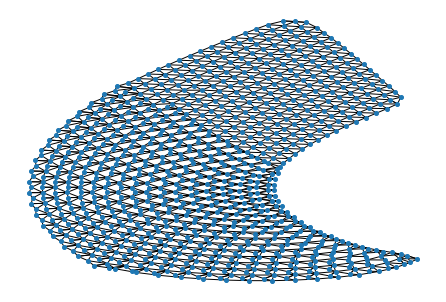

In [296]:
nx.draw_kamada_kawai(graph, node_size=16)
print(peo[4100:])
print(sorted(graph.degree, key=lambda x: x[1]))
print(sorted([ utils.edges_to_clique(graph, x[0]) for x in graph.degree]))

# Parallelize after critical point

2020-03-07 22:53:01,551- INFO•	Removed indices by parallelization:
[1849, 1851, 1853, 1855, 1857, 1859, 1861, 1863, 1865, 1867, 1869, 1875]
2020-03-07 22:53:01,552- INFO•	Removed 12 variables


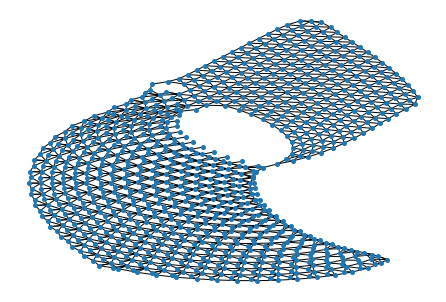

In [297]:
par_vars, graph_split = qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=12)
nx.draw_kamada_kawai(graph_split, node_size=16)

## Late paralelisaton with simple reorder

15399.6052399
466192.930177024


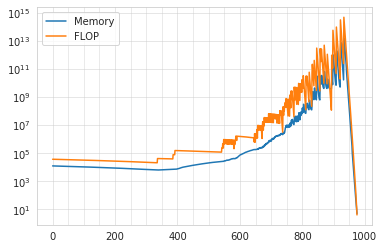

In [298]:
graph_opt, nghs = _optimise_graph(graph)
mems, flops = qtree.graph_model.cost_estimator(graph_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

3.792699604
281.320357888


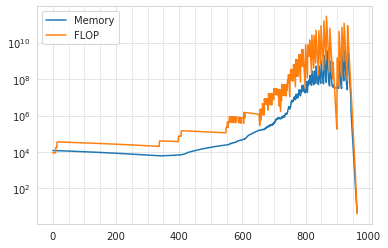

In [299]:
graph_split_opt, nghs = _optimise_graph(graph_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)


## Late paralelisaton with qbb reorder

2020-03-07 22:54:09,888- INFO•	generating config file output/quickbb.15109032.cnf
2020-03-07 22:54:09,894- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.15109032.cnf 


30.232330426
1872.605741056


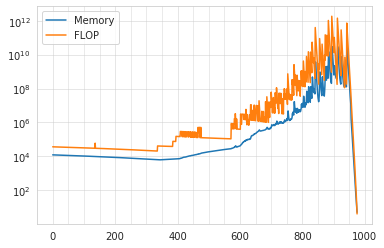

In [300]:
peoqbb, tw = qtree.graph_model.get_peo(graph)
graph_opt_relabel, nghs = utils.reorder_graph(graph, peoqbb)
mems, flops = qtree.graph_model.cost_estimator(graph_opt_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

In [301]:
peoqbb_split, tw = qtree.graph_model.get_peo(graph_split)

2020-03-07 22:56:58,904- INFO•	generating config file output/quickbb.17300869.cnf
2020-03-07 22:56:58,909- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.17300869.cnf 


15.038677056
369.367187456


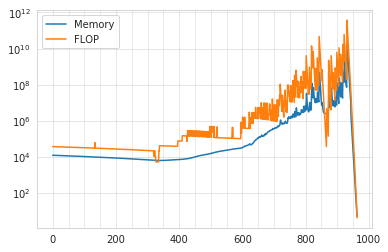

In [302]:
graph_split_relabel, nghs = utils.reorder_graph(graph_split, peoqbb_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

In [303]:
for n in peo[4100:4100+700]:
    qtree.graph_model.eliminate_node(graph, n)
    

/usr/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


[1643, 1647, 1665, 1677, 1699, 1707, 1719, 1749, 1775, 1783, 1791, 1843, 1849, 1855, 1863, 1923, 1931, 1951, 1971, 1973, 1993, 2001, 2045, 2061, 2069, 2109, 2111, 2117, 2135, 2175, 2183, 2203, 2223, 2247, 2249, 2277, 2289, 2333, 2349, 2357, 2363, 2421, 2429, 2437, 2463, 2477, 2479, 1367, 1401, 1437, 2493, 2529, 2505, 2541, 1307, 1343, 1379, 1621, 1623, 1727, 1761, 2019, 2053, 2159, 2193, 2227, 2379, 2413, 2407, 2409, 2445, 2447, 2499, 1351, 1353, 1355, 1509, 1511, 1463, 1465, 1467, 1805, 1839, 1957, 1959, 1961, 1965, 1967, 1977, 2013, 2165, 2199, 1415, 1417, 1449, 1555, 1557, 1559, 1599, 1601, 1603, 1645, 1739, 1741, 1743, 1753, 1755, 1757, 1819, 1821, 1917, 2147, 2181, 2177, 2211, 2255, 2257, 2311, 2313, 2315, 2331, 2365, 2405, 2441, 2475, 2455, 2457, 2459, 2097, 2099, 2119, 2155, 2469, 2471, 2473, 2509, 2543, 2579, 1471, 1507, 1541, 1661, 1697, 1901, 1423, 2391, 2393, 2033, 2035, 2037, 2369, 2399, 2401, 2403, 2433, 2417, 2453, 2489, 2525, 2559, 1687, 1723, 1759, 1795, 1875, 1877, 190

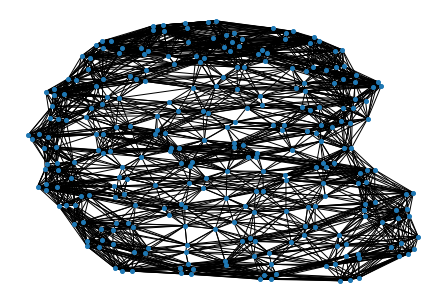

In [304]:
nx.draw_kamada_kawai(graph, node_size=16)
print(peo[4700:])
print(sorted(graph.degree, key=lambda x: x[1]))
print(sorted([ utils.edges_to_clique(graph, x[0]) for x in graph.degree]))

# Second parallelize after critical point 

2020-03-07 23:03:02,157- INFO•	Removed indices by parallelization:
[1631, 1469, 1425, 1733, 2085, 2093, 1881, 1919, 2113, 2115, 2395, 1535]
2020-03-07 23:03:02,158- INFO•	Removed 12 variables


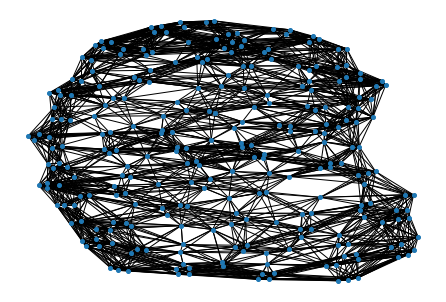

In [306]:
par_vars, graph_split = qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=12)
nx.draw_kamada_kawai(graph_split, node_size=16)

## Late paralelisaton with simple reorder

15399.6052399
466192.930177024


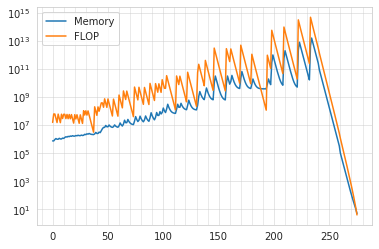

In [307]:
graph_opt, nghs = _optimise_graph(graph)
mems, flops = qtree.graph_model.cost_estimator(graph_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

481.04262869
13194.139533312


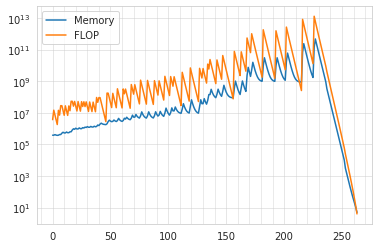

In [308]:
graph_split_opt, nghs = _optimise_graph(graph_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_opt)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)


## Late paralelisaton with qbb reorder

2020-03-07 23:03:41,196- INFO•	generating config file output/quickbb.14131456.cnf
2020-03-07 23:03:41,201- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.14131456.cnf 


15.061729544
1322.849927168


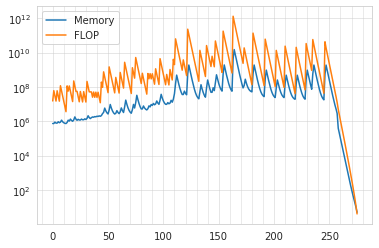

In [309]:
peoqbb, tw = qtree.graph_model.get_peo(graph)
graph_opt_relabel, nghs = utils.reorder_graph(graph, peoqbb)
mems, flops = qtree.graph_model.cost_estimator(graph_opt_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

In [310]:
peoqbb_split, tw = qtree.graph_model.get_peo(graph_split)

2020-03-07 23:04:46,202- INFO•	generating config file output/quickbb.20870916.cnf
2020-03-07 23:04:46,206- INFO•	excecuting quickbb: ./quickbb/quickbb_64  --min-fill-ordering --time 60 --cnffile output/quickbb.20870916.cnf 


0.472391882
40.2653184


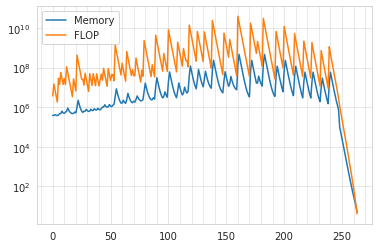

In [311]:
graph_split_relabel, nghs = utils.reorder_graph(graph_split, peoqbb_split)
mems, flops = qtree.graph_model.cost_estimator(graph_split_relabel)
print(max(mems)/1e9)
print(max(flops)/1e9)
utils.plot_cost(mems, flops)

114 78.0
[(1537, 1537), (1538, 1538), (1570, 1570), (1541, 1541), (1608, 1608), (1611, 1611), (1612, 1612), (1613, 1613), (1586, 1586), (1493, 1493), (1595, 1595), (1532, 1532), (1533, 1533)]
78
0


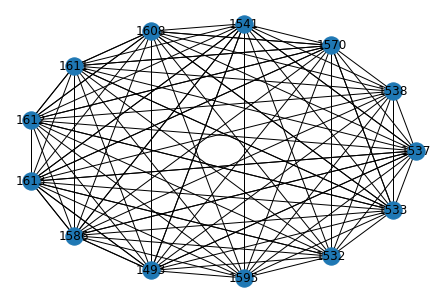

In [138]:
sg = graph.subgraph([1538] + list(graph.neighbors(1538)))
N = sg.number_of_nodes()
print(sg.number_of_edges(), 1/2*N*(N-1))
print(list(sg.selfloop_edges()))
edges = [e for e in graph.edges if all([e[-1]==0]+[x in sg.nodes for x in e[:2]])]
print(len(edges))
print(utils.edges_to_clique(graph, 1538))

nx.draw_shell(sg, with_labels=True)


## Profiling actual simulation


In [ ]:
from pyrofiler import mem_util, timed, timing
from pyrofiler.callbacks import append_to

In [ ]:
profile = {}

@mem_util(description='mem', callback=append_to(profile))
@timed('time', callback=append_to(profile))
@log.catch()
def simulate_circ(circuit, n_qubits):
    buckets, data_dict, bra_vars, ket_vars = qtree.optimizer.circ2buckets(
        n_qubits, circuit)

    graph = qtree.graph_model.buckets2graph(
        buckets,
        ignore_variables=bra_vars+ket_vars)

    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    peo = qtree.graph_model.indices_to_vars(peo, graph)
    
    # place bra and ket variables to beginning, so these variables
    # will be contracted first
    #peo, treewidth = qtree.graph_model.get_peo(graph)

    peo = ket_vars + bra_vars + peo
    perm_buckets, perm_dict = qtree.optimizer.reorder_buckets(buckets, peo)

    # extract bra and ket variables from variable list and sort according
    # to qubit order
    ket_vars = sorted([perm_dict[idx] for idx in ket_vars], key=str)
    bra_vars = sorted([perm_dict[idx] for idx in bra_vars], key=str)

    # Take the subtensor corresponding to the initial state
    initial_state = target_state = 0
    slice_dict = qtree.utils.slice_from_bits(initial_state, ket_vars)
    slice_dict.update(
        qtree.utils.slice_from_bits(target_state, bra_vars)
    )
    sliced_buckets = qtree.np_framework.get_sliced_np_buckets(
        perm_buckets, data_dict, slice_dict)
    
    with timing('time_raw', callback=append_to(profile)):
        result = qtree.optimizer.bucket_elimination(
            sliced_buckets, qtree.np_framework.process_bucket_np)
        

In [ ]:
for key in profile:
    profile[key] = []
    
profile['N'] = []
sizes = np.arange(5,27) 

for S in sizes[:]:
    qc, N = get_test_qaoa(S)
    profile['N'].append(N)
    print(N,'qubits')
    result = simulate_circ(qc, N)

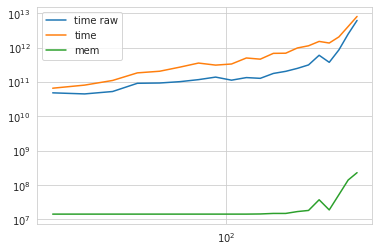

In [81]:
ns = profile['N']

def to_flop(secs):
    secs = np.array(secs)
    secs *= .3*1e12
    return secs
def to_nums(mems):
    mems = np.array(mems)
    mems = mems/16
    return mems

mems = to_nums(profile['mem'])
#mems -= np.min(mems)


plt.plot(ns, to_flop(profile['time_raw']), label='time raw')
plt.plot(ns, to_flop(profile['time']), label='time')
plt.plot(ns, mems, label='mem')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [ ]:
# Sizes for theory
sizes = np.arange(3,21)

In [ ]:
results = [
   get_cost_of_task(s) for s in sizes
]
sums = [[sum(x) for x in y[:3]] for y in results]
memsums, flopsums, nghssums = zip(*sums)
ns_theory = list(zip(*results))[3]

In [ ]:
est, mem_est = get_est(ns_theory, memsums)
est, flop_est = get_est(ns_theory, flopsums)

fig, axs = plt.subplots(1,2, figsize=(12,5))

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.plot(ns_theory, memsums, label='theory')
plt.plot(ns, mems, label='experiment')
plt.plot(est, mem_est, '--', label='log-log fit')
plt.legend()
plt.title('Memory')
plt.xlabel('Number of qbits')

plt.sca(axs[1])
log_log_scale()
minorticks()
plt.plot(ns_theory, flopsums, label='theory')
plt.plot(ns, to_flop(profile['time']), label='experiment')
plt.plot(ns, to_flop(profile['time_raw']), label='experiment raw')
plt.plot(est, flop_est, '--', label='log-log fit')

plt.xlabel('Number of qbits')

plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
plt.title('FLOP')
plt.legend()


In [ ]:
filename = 'qaoa_cost_theory_exp'
plt.savefig(f'qaoa/figures/{filename}.png')
plt.savefig(f'qaoa/figures/{filename}.pdf')